## Utility functions and general imports

In [1]:
import h5py
import numpy as np
import scipy as scpy
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from scipy import optimize as opt
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline


In [20]:
# Defining utility functions for reading images and data in
def show_image(array, label):
    im = Image.fromarray(array)
    print("Item of label={}".format(label))
    return(imshow(im))

def construct_conf_mat(actual_y, predicted_prob, pos_class_label, thresh=0.5):
    fp, tp, fn, tn = 0, 0, 0, 0
    for i in range(actual_y.shape[0]):
        if predicted_prob[i] >= thresh:
            if actual_y[i] == pos_class_label:
                tp += 1
            else:
                fp += 1
        else:
            if actual_y[i] == pos_class_label:
                fn += 1
            else:
                tn += 1
    return fp, tp, fn, tn
    
    
def compress_project(percent, data_to_compress):

# Find the principal components that explain 99% of the data
    pca = decomposition.PCA(percent)

    #Run PCA on normalized image data
    lower_dim_data = pca.fit_transform(data_to_compress)    
    print('Shape of lower dimension image {}:'.format(lower_dim_data.shape))

    #Project lower dimension data onto original features
    approximation = pca.inverse_transform(lower_dim_data)
    #approximation = pca.inverse_transform(lower_dim_data)
        
    #Reshape approximation and X_norm to 784*28*28 to display images
    approximation_reshaped = approximation.reshape(-1,784)
    print('Shape of reconstructed image {}:'.format(approximation_reshaped.shape))   
    print( 'Is Original close to Resized? ', np.allclose(data_to_compress, approximation) )
    
    return (approximation, lower_dim_data) 


def shape_matrix_process(split_percent):
    
            
        # Read the source files in
        data, label, test_data, test_label = read_data_in(desktop_or_laptop='d')

        # Creating a fair split of training and validation data for the 
        # training model to be trained on
        indices = range(data.shape[0])
        classes = np.unique(label)
        
        training_records = int(split_percent * data.shape[0])        
        
        # Get the records that are part of the indices declared above
        train_data = data[:training_records]
        validate_data = data[training_records:]        
        
        # Get the labels that are part of the indices declared above
        label_train = label[:training_records]
        label_validate = label[training_records:]        
        
        
        get_class_data = np.vectorize(lambda arr: label==i )
                
        
        for i in classes:
            print("Pixel histogram prior to feature scaling : ".format(classes[i]))
            print(i)
        
            d=[]
            d = data[get_class_data(i)]
            h = plt.hist(d[i].ravel())
            plt.show()

        X_train = train_data.reshape(-1, 784)
        X_validate = validate_data.reshape(-1, 784)
        #X_scaled_data = data.reshape(-1,784)
        X_train.shape
        
        y_train = np.ravel(label_train)
        y_validate = np.ravel(label_validate)    

                
        ##########################################################################  
        # MINMAXSCALER IS THE ONLY SCALER FOUND TO RELIABLY RESULT IN CONVERGENCE*
        # HOWEVER NEEDS FURTHER TESTING =========================================#
        ##########################################################################

        #X_train = preprocessing.scale(X_train)
        #min_max_scaler = MinMaxScaler()
        # Fit & transform to our training data set
        X_train = X_train.astype('float32')
        #X_train = min_max_scaler.fit_transform(X_train,y_train)
        X_train = normalise(X_train)
        
        
        # Change our X_Validate data set to float 32 to 
        
        X_validate = X_validate.astype('float32')
        X_validate = normalise(X_validate)
                
        
        
        
        # How does the 'data' array look post feature scaling?
        
        #for i in classes:
        #    print("Pixel histogram post to feature scaling : ".format(classes[i]))
        #    print(i)
        # 
        #    d=[]
        #    d = X_scaled_data[get_class_data(i)]
        #    h = plt.hist(d[i].ravel())
        #    plt.show()
        
        
        print('Total number of records in X train: {}'.format(X_train.shape[0]))
        print('Total number of records in y train: {}'.format(y_train.shape[0]))
        print('Total number of features in X train: {}'.format(X_train.shape[1]))

        print('Total number of records in X train (valdation set): {}'.format(X_validate.shape[0]))
        print('Total number of features in X train (validation set): {}'.format(X_validate.shape[1]))
        
       
        ########################
        # Now to transform test#
        ########################
        
        X_test = test_data[:2000]        
        X_test = test_data.reshape(-1,784)
        y_test = test_label [:2000]       
        X_test = X_test.astype('float32')
            
        ##########################################################################  
        # MINMAXSCALER IS THE ONLY SCALER FOUND TO RELIABLY RESULT IN CONVERGENCE*
        # HOWEVER NEEDS FURTHER TESTING =========================================#
        ##########################################################################

   
        X_test = normalise(X_test)
                                          
        print('Total number of records in X test: {}'.format(X_test.shape[0]))
        print('Total number of features in X test: {}'.format(X_test.shape[1]))
        
        return(X_train,X_validate,X_test,y_train,y_validate,y_test)
    
    
# Import the files in from python h5 format


def read_data_in(desktop_or_laptop='d'):
    
    if desktop_or_laptop == 'l':

        ## Dan's Mac folder location - NEEDS CHANGING
        with h5py.File('../Project1/data/images_training.h5','r') as H:
            data = np.copy(H['data'])
        with h5py.File('../Project1/data/labels_training.h5','r') as H:
            label = np.copy(H['label'])

        with h5py.File('../Project1/data/images_testing.h5','r') as H:
            data_test = np.copy(H['data'])
        with h5py.File('../Project1/data/labels_testing_2000.h5','r') as H:
            label_test = np.copy(H['label'])    


    else:
        ## Dan's desktop folder location - NEEDS CHANGING
        with h5py.File('../../Input/images_training.h5','r') as H:
            data = np.copy(H['data'])
        with h5py.File('../../Input/labels_training.h5','r') as H:
            label = np.copy(H['label'])
        with h5py.File('../../Input/images_testing.h5','r') as H:
            data_test = np.copy(H['data'])

        with h5py.File('../../Input/labels_testing_2000.h5','r') as H:
            label_test = np.copy(H['label'])     
    
    return(data, label, data_test, label_test)

def add_intercept(X_mat,y_mat):
    m = len(y_mat)
    ones = np.ones((m,1))
    
    X = np.concatenate((ones,X_mat),axis=1)
    m,n = X.shape
    print(X.shape)
    return(X,n)

# Is the matrix symmetric?
def is_symmetric(X, tolerance = 1e-9):
    return(np.allclose(X,X.T, atol=tolerance))

def get_minmax(X):
    minmax = list()
    for i in range(len(X[0])):
        column_values = [row[i] for row in X]
        mn = min(column_values)
        mx = max(column_values)
        minmax.append([mn,mx])
    return(minmax)

def normalise(X):
    #print(X_train.shape)
    X_scaled = (X - np.min(X,axis=0)) / (np.max(X, axis=0) - (np.min(X,axis=0) ))
    return(X_scaled)


class LogisticRegression:
    def __init__(self,  max_iter, intercept, k, lmbda ):
        #self.lr = lr
        self.max_iter = max_iter
        self.intercept = intercept
        self.k = k
        self.lmbda = lmbda
        print ("Logistic Regression model initialised with Max iterations = {}, K (classes) = {}, lmbda (Regularisation parameter) ={}".format(self.max_iter,self.k, self.lmbda))
    
    def add_intercept(self, X_mat,y_mat):
        m = len(y_mat)
        ones = np.ones((m,1))

        X_mat = np.concatenate((ones,X_mat),axis=1)
        m_shape,n_shape = X_mat.shape
        #print("n_shape: {}".format(n_shape))
        #print("X_mat.shape: {}".format(X_mat.shape))
        
        return(X_mat,n_shape)
    
    # Defining the sigmoid function required in LR
    def __sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def __cost(self, theta, X_arr, y_arr):
        predictions = self.__sigmoid(X_arr @ theta)
        predictions[predictions == 1] = 0.999 # log(1)=0 causes error in division
        error = -y_arr * np.log(predictions) - (1 - y_arr) * np.log(1 - predictions);
        return sum(error) / len(y_arr);
    
    # Vectorised cost function
    def __costFunctionReg(self,theta, X, y, lmbda):
        m = len(y)
        temp1 = np.multiply(y, np.log(self.__sigmoid(np.dot(X, theta))))
        temp2 = np.multiply(1-y, np.log(1-self.__sigmoid(np.dot(X, theta))))  
        #print(np.sum(temp1 + temp2) / (-m) + np.sum(theta[1:]**2) * lmbda / (2*m))
        return np.sum(temp1 + temp2) / (-m) + np.sum(theta[1:]**2) * lmbda / (2*m)
    
    
    def fit(self, X_mat,max_iter, y_mat,n, full_outp):
                        
        theta = np.zeros((k,n)) #inital parameters
        cost_values = {}
        
        
        print("                                            ")
        print("############################################")
        print("### Gradient Descent Optimisation beginning")
        print("############################################")
        for i in range(k):
            label_class = i if i else 0
            print('Class {} being optimised'.format(i))
            #cost0 = cost(theta, X, (y==label_class.flatten()))
            #cost[i] = cost(theta[i], X,y)
            #print('Cost for Class {}:'.format(cost[i]))               
            #ValueError: cannot copy sequence with size 5 to array axis with dimension 785
            theta[i] = opt.fmin_cg(f = self.__costFunctionReg, x0 = theta[i].flatten(), gtol = 1e-03, fprime = self.__gradient_reg_vectorised, args = (X_mat,(y_mat == label_class).flatten(), self.lmbda),maxiter= max_iter, disp = True, full_output = full_outp)                        
            #cost = {i,}
            #theta[i] = opt.fmin_cg(f = costFunctionReg, x0 = theta[i].flatten(),  fprime = gradRegularization, args = (X_mat,(y == label_class).flatten(), lmbda), maxiter = 200, disp = True)    
            
        print("###########################################")
        print("### Gradient Descent Optimisation finished")
        print("###########################################")
            #if full_outp == 1:
            #    return(theta, fopt, func_calls, grad_calls, warnflag)
            #else:
            #    return(theta)
        return(theta)
    
      
    
    # Vectorised gradient
    def __gradient_reg_vectorised(self, theta, X_arr, y_arr, lmbda):
        m = len(y_arr)
        temp = self.__sigmoid(np.dot(X_arr, theta)) - y_arr
        temp = np.dot(temp.T, X_arr).T / m + theta * lmbda / m
        temp[0] = temp[0] - theta[0] * lmbda / m
        return temp
    
    # Vectorised cost function
    def __cost_func_vectorised(self,theta, X_arr, y_arr, lmbda):
        m = len(y_arr)
        temp_weight1 = np.multiply(y_arr, np.log(self.__sigmoid(np.dot(X_arr, theta))))
        temp_weight2 = np.multiply(1-y_arr, np.log(1-self.__sigmoid(np.dot(X_arr, theta))))
        return np.sum(temp_weight1 + temp_weight2) / (-m) + np.sum(theta[1:]**2) * self.lmbda / (2*m)
    
    
    def predict(self,X,y,theta):    
        preds = []
        preds = np.argmax(X @ theta.T, axis = 1)
        preds = [e if e else 0 for e in preds]
        average_pred = np.mean(preds == y.flatten()) * 100        
        return(preds, average_pred)
        #return(average_pred)
    
    def predict_prob(self,X, theta):
        return (self.__sigmoid(np.dot(X),theta.T))
    
        
    

## For reference: https://github.com/zalandoresearch/fashion-mnist



| Label | Description   |
|------|------|
|   0  | T-shirt/top|
|   1  | Trouser|
|   2  | Pullover|
|   3  | Dress|
|   4  | Coat|
|   5  | Sandal|
|   6  | Shirt|
|   7  | Sneaker|
|   8  | Bag|
|   9  | Ankle boot|

In [ ]:
data, label, data_test, label_test = read_data_in(desktop_or_laptop='d')

train_data = data[:30000]

X_train = train_data.reshape(-1, 784)


#def is_symmetric(X, tolerance = 1e-9):
#    return(np.allclose(X,X.T, atol=tolerance))


 #= data.reshape[-1,784]
#is_sparse(X_train,X_train.shape[0],X_train.shape[1])
#X.shape
#scpy.sparse.isspmatrix(train_data)

#X_train.shape
#data.reshape[-1,784]
#data[3]

In [ ]:
label==0

In [ ]:
# Creating histograms for all classes to see pixel distributions
#bin_counts, no_of_bins = np.histogram(data,10)

#plt.hist(x = data.ravel(), bins = no_of_bins)


get_class_data = np.vectorize(lambda arr: label==i )

for i in classes:
    #print("Pixel histogram for label : ".format(classes[i]))
    print(i)
    
    d=[]
    d = data[get_class_data(i)]
    h = plt.hist(d[i].ravel())
    plt.show()
    
    

    

In [ ]:
X_train,X_validate,X_test,y_train,y_validate,y_test = shape_matrix_process(split_percent=0.9)

#get_class_data = np.vectorize(lambda arr: label==i )

#for i in classes:
    #print("Pixel histogram for label : ".format(classes[i]))
    #print(i)
    
#    d=[]
#    d = X_train[get_class_data(i)]
#    h = plt.hist(d[i].ravel())
#    plt.show()


In [ ]:
i = 10
#show_image(data[i],label[i])

#print('Total training data shape : ', data.shape, label.shape)
#data_train = data_train / 255


_, axarr = plt.subplots(10,10,figsize=(10,10))

for i in range(10):
    for j in range(10):
       data[np.random.randint(data.shape[0])] 
       axarr[i,j].axis('off')     


## Basic Exploratory Analysis

In [ ]:
# How many unique classes are we dealing with? Do we need to perform any sampling for class imbalance?
classes = np.unique(label)
nclasses = len(classes)
test_classes = np.unique(label_test)
test_nclasses = len(test_classes)


print('Total number of classes in Train: ', nclasses)
print('Total number of classes in Test : ', test_nclasses)
print('Classes to classify in Train are : ', classes)
print('Classes to classify in Test are : ', test_classes)


unique, counts = np.unique(label, return_counts=True)
print('Distribution of labels against total population in Train:')
dict(zip(unique,counts))

unique_test, count_test = np.unique(label_test, return_counts=True)
print('Distribution of labels against total population in Test:')
dict(zip(unique_test,count_test))




## Setting up terms, intercept and gradients for LogisticRegression - OVR

Pixel histogram prior to feature scaling : 
0


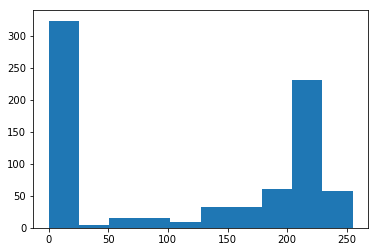

Pixel histogram prior to feature scaling : 
1


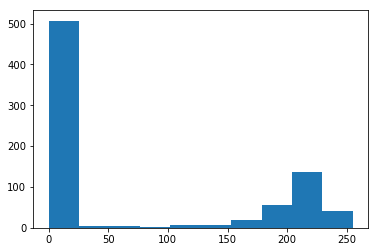

Pixel histogram prior to feature scaling : 
2


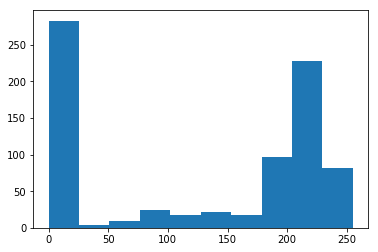

Pixel histogram prior to feature scaling : 
3


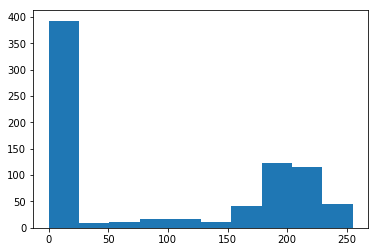

Pixel histogram prior to feature scaling : 
4


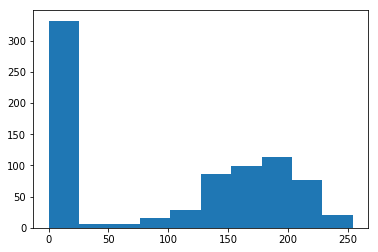

Pixel histogram prior to feature scaling : 
5


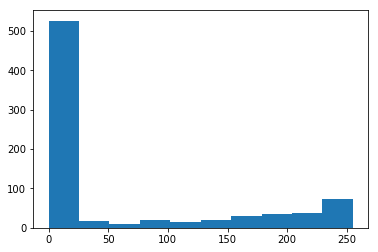

Pixel histogram prior to feature scaling : 
6


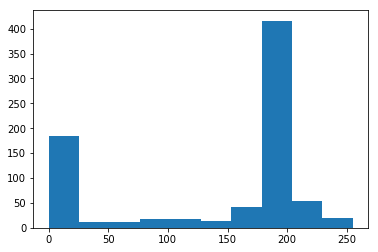

Pixel histogram prior to feature scaling : 
7


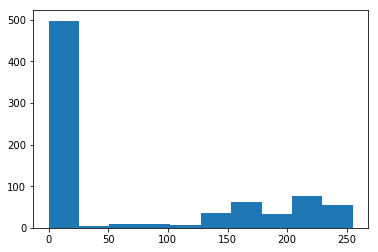

Pixel histogram prior to feature scaling : 
8


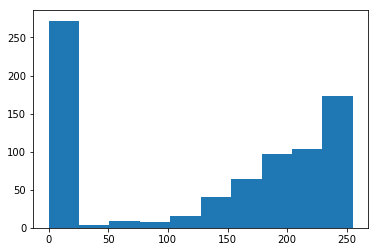

Pixel histogram prior to feature scaling : 
9


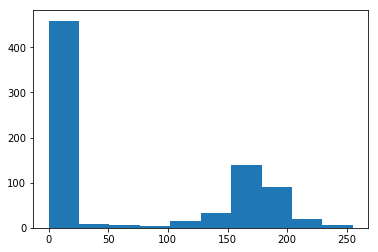

C:\Users\New\Anaconda3\lib\site-packages\ipykernel\__main__.py:208: RuntimeWarning: invalid value encountered in true_divide


Total number of records in X train: 29700
Total number of records in y train: 29700
Total number of features in X train: 784
Total number of records in X train (valdation set): 300
Total number of features in X train (validation set): 784
Total number of records in X test: 5000
Total number of features in X test: 784
#################################################
Logistic Regression model initialised with Max iterations = 500, K (classes) = 10, lmbda (Regularisation parameter) =2
#################################################
                                            
############################################
### Gradient Descent Optimisation beginning
############################################
Class 0 being optimised
Optimization terminated successfully.
         Current function value: 0.098526
         Iterations: 42
         Function evaluations: 86
         Gradient evaluations: 86
Class 1 being optimised
Optimization terminated successfully.
         Current function

In [16]:
%%time

loop_count = 1

prediction_average_test = []

for i in range(loop_count):

    # Read the source files in
    data, label, data_test, label_test = read_data_in(desktop_or_laptop='d')

    # Declare variables for instantiation of the LogisticRegression Class
    lmbda = 2
    k = 10
    intercept = True
    max_iter = 500

    #n = []
    # THIS IS A HACK, NOT SURE WHY TEST DATA ISN'T BEING READ IN PROPERLY CURRENTLY
    data_test = data_test[:2000]

    #########################################################################################
    # Once data is read in from file data, we split it for training, validation and testing #
    # standardise, & re-shape it process                                                    #
    #########################################################################################
        
    X_train,X_validate,X_test,y_train,y_validate,y_test = shape_matrix_process(split_percent=0.99)
    X_test = X_test[:2000]


    ############################################
    # Instantiate our logistic Regression model#
    ############################################
    print('#################################################')
    model = LogisticRegression(max_iter, intercept, k, lmbda)
    print('#################################################')

    # Carry out principal component analysis and project back with 99% of variance
    #X_train, X_reduced  = compress_project(percent=.99,data_to_compress=X_train)

    # Add the intercept value
    X_train,n = model.add_intercept(X_train,y_train)

    # Create a theta matrix to capture values of theta when we minimis the objective function below
    theta = np.zeros((k,n)) #inital parameters

    #############################################################################################
    # Using conjugate gradient, we attempt to carry out optimisation to find theta and therefore#
    # Using theta and the data features to predict each class   #################################
    #############################################################################################
    
    # Do you want to see a verbose/full output for conjugate gradient descent?
    
    #theta = model.fit(X_mat=X_train,max_iter=500,y_mat=y_train,n=n, full_outp=False)
    
    
    #theta, fopt, func_calls, grad_calls,warnflag  = model.fit(X_mat=X_train,max_iter=500,y_mat=y_train,n=n, full_outp=False)
    theta  = model.fit(X_mat=X_train,max_iter=500,y_mat=y_train,n=n, full_outp=False)
        
    
    #######################################################################################
    # Carry out the predictions based on the trained model and then carry out predictions #
    # on the unseen test data                                                             #
    #######################################################################################
    X_test,n = model.add_intercept(X_test,y_test)

    #prediction_average_test.append(model.predict(X_test,y_test,theta=theta))
    #prediction_average_test.append(model.predict(X_test,y_test,theta=theta))
    #prediction_average_test

# With feature scaling (min/max) - Convergence of all classes
# Wall time: 2min 6s

#CPU times: user 4min 13s, sys: 2.81 s, total: 4min 16s
#Wall time: 2min 14s

# CPU times: user 4min 22s, sys: 1.55 s, total: 4min 24s
# Wall time: 2min 15s


# 5 time loop of 
# CPU times: user 21min 56s, sys: 9.06 s, total: 22min 5s
# Wall time: 11min 22s

# CPU times: user 22min 5s, sys: 10.4 s, total: 22min 15s
# Wall time: 11min 35s


##########################################################
# Without feature scaling - Convergence of all classes
# CPU times: user 9min 29s, sys: 5.33 s, total: 9min 35s
# Wall time: 5min 3s

# CPU times: user 9min 8s, sys: 2.48 s, total: 9min 10s
# Wall time: 4min 47s

# CPU times: user 9min 17s, sys: 2.7 s, total: 9min 20s
# Wall time: 4min 48s

In [21]:
#prediction_average = []
preds, prediction_average = model.predict(X=X_train,y=y_train,theta=theta)
prediction_average

#X_test,n = model.add_intercept(X_test,y_test)
prediction_average_test = []
#prediction_average_test = model.predict(X_test,y_test,theta=theta)
preds_test,prediction_average_test   = model.predict(X_test,y_test,theta=theta)
prediction_average_test
#preds_test


#87.68771929824561
# 84.0

#87.51578947368421
#84.0

85.6026936026936

84.0

## Finding the optimal weights and parameters for the 10 classes

In [23]:
preds
y_train

[0,
 2,
 0,
 5,
 4,
 2,
 2,
 7,
 5,
 5,
 5,
 8,
 4,
 2,
 8,
 3,
 7,
 1,
 9,
 8,
 6,
 0,
 9,
 4,
 8,
 2,
 6,
 8,
 6,
 0,
 1,
 7,
 7,
 9,
 0,
 3,
 5,
 6,
 7,
 2,
 8,
 3,
 8,
 0,
 8,
 3,
 5,
 0,
 5,
 0,
 4,
 7,
 3,
 7,
 4,
 9,
 6,
 0,
 3,
 7,
 0,
 0,
 0,
 8,
 3,
 0,
 9,
 0,
 3,
 0,
 5,
 7,
 5,
 5,
 7,
 2,
 6,
 3,
 1,
 7,
 5,
 8,
 4,
 4,
 2,
 3,
 9,
 4,
 0,
 2,
 5,
 0,
 4,
 6,
 9,
 4,
 8,
 4,
 2,
 2,
 1,
 3,
 7,
 9,
 6,
 6,
 6,
 8,
 5,
 1,
 8,
 2,
 3,
 1,
 3,
 9,
 5,
 4,
 7,
 0,
 2,
 7,
 9,
 9,
 8,
 7,
 3,
 4,
 4,
 4,
 9,
 6,
 3,
 8,
 3,
 4,
 1,
 6,
 2,
 0,
 8,
 4,
 9,
 2,
 1,
 8,
 4,
 5,
 5,
 4,
 9,
 9,
 1,
 5,
 3,
 5,
 2,
 3,
 4,
 7,
 2,
 3,
 6,
 2,
 3,
 2,
 0,
 3,
 9,
 6,
 5,
 3,
 4,
 8,
 3,
 8,
 5,
 8,
 1,
 9,
 9,
 0,
 5,
 2,
 4,
 0,
 9,
 3,
 4,
 0,
 2,
 4,
 1,
 9,
 7,
 4,
 0,
 8,
 2,
 7,
 0,
 8,
 0,
 5,
 8,
 3,
 8,
 8,
 0,
 7,
 7,
 7,
 6,
 8,
 2,
 5,
 1,
 2,
 4,
 1,
 4,
 0,
 2,
 7,
 2,
 3,
 0,
 0,
 5,
 3,
 3,
 6,
 2,
 8,
 1,
 9,
 4,
 6,
 0,
 3,
 7,
 8,
 0,
 4,
 5,
 4,
 6,
 3,
 0,
 3,


array([0, 2, 6, ..., 5, 2, 9], dtype=uint8)

In [ ]:
lmbda = 5
k = 10
max_iter = 275


#X=data_test
#y=label_test
#train_or_test='test'

#X_test,y_test = shape_matrix_process(X_test, y_test, train_or_test, split_percent)
#X_test, n_train = add_intercept(X_test,y_test)

theta = np.zeros((k,n)) #inital parameters

# Time execution of the gradient descent and cost calculations
%timeit -n 1 -r 1 theta = create_multiclass_c(X_mat=X_train, max_iter=max_iter, y_mat=y_train,n=n)
#%timeit -n 1 -r 1 theta = create_multiclass_c(X_validate,n, max_iter, y_validate)

In [ ]:
X_test,n = add_intercept(X_test,y_test)

pred = []
pred = np.argmax(X_test @ theta.T, axis = 1)
pred = [e if e else 0 for e in pred]
np.mean(pred == y_train.flatten()) * 100

#79.74166666666666

In [ ]:

preds = np.argmax(X_train @ theta.T, axis = 1)
preds = [e if e else 0 for e in pred]
np.mean(preds ==y_train.flatten()) * 100
#79.74166666666666

In [ ]:
preds_test[0:10]
y_test

In [ ]:
pred_validate = []
pred_validate = np.argmax(X_validate @ theta.T, axis = 1)
pred = [e if e else 0 for e in pred]
pred_accuracies = pred_validate == y_validate.flatten()
np.mean(pred_validate ==y_validate.flatten()) * 100
#79.74166666666666

In [ ]:
pred_train = []
pred_train = np.argmax(X_train @ theta.T, axis = 1)
pred = [e if e else 0 for e in pred_train]
np.mean(pred_train == y_train.flatten()) * 100

pred_test = []
pred_test = np.argmax(X_test @ theta.T, axis = 1)
pred = [e if e else 0 for e in pred_test]
np.mean(pred_test == y_test.flatten()) * 100

#79.74166666666666

In [ ]:
print(pred_test)
print(y_test)

In [ ]:
label_test

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, preds_test)
#cm = metrics.confusion_matrix(y_train, preds)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(prediction_average_test)
plt.title(all_sample_title, size = 15);

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Using Gaussian Naive Bayes as alternate classifier

In [ ]:
y.shape

In [ ]:
from sklearn.naive_bayes import GaussianNB


# Trying with train
gnb = GaussianNB().fit(X,y)
gnb_pred = gnb.predict(X_validate)

gnb_accuracy = gnb.score(X_validate,y_validate)
print(gnb_accuracy)

